# Evaluation Run Log Analysis and Visualization for AWS DeepRacer

This notebook walks through how you can analyze and debug using the AWS DeepRacer Simulation logs 

```
1. Tools to find best iteration of your model
2. Visualize reward distribution on the track
  2.1 Visualize reward heatmap per episode or iteration
3. Identify hotspots on the track for your model
4. Understand probability distributions on simulated images
5. Evaluation run analysis - plot lap speed heatmap
```

## Requirements

boto3 >= 1.9.133  ; configure your aws cli and/or boto credentials file

AWS CLI: https://docs.aws.amazon.com/cli/latest/userguide/cli-chap-configure.html

Boto Configuration: https://boto3.amazonaws.com/v1/documentation/api/latest/guide/configuration.html

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline

#Shapely Library
from shapely.geometry import Point, Polygon
from shapely.geometry.polygon import LinearRing, LineString

import track_utils as tu
import log_analysis as la
import cw_utils as cw

# Make sure your boto version is >= '1.9.133'
cw.boto3.__version__

'1.9.210'

In [2]:
# reload log_analysis here if needed
# I use this when I update python files in log-analysis folder
import importlib
importlib.reload(la)
importlib.reload(cw)
importlib.reload(tu)

<module 'track_utils' from '/home/ccsantos/deepracer-for-dummies/aws-deepracer-workshops/log-analysis/track_utils.py'>

## Load waypoints for the track you want to run analysis on

Tracks Available:

In [3]:
!ls tracks/

AWS_track.npy	  London_Loop_Train.npy    reinvent_base.npy
Bowtie_track.npy  New_York_Eval_Track.npy  Straight_track.npy
China_track.npy   New_York_Track.npy	   Tokyo_Training_track.npy
H_track.npy	  Oval_track.npy	   Virtual_May19_Train_track.npy


Loaded 71 waypoints


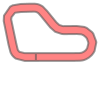

In [4]:
l_center_line, l_inner_border, l_outer_border, road_poly = tu.load_track("reinvent_base")

road_poly

## Load all evaluation logs

**WARNING:** If you do not specify `not_older_than` parameter, all evaluation logs will be downloaded. They aren't as big as the training logs, but there is a lot of them.

That said you can download all and then it will only download new ones unless you use force=True.

There are also `not_older_than` and `older_than` parameters so you can choose to fetch all logs from a given period and compare them against each other. Just remember memory is finite.

As mentioned, this method always fetches a list of log streams and then downloads only ones that haven't been downloaded just yet. You can therefore use it to fetch that list and load all the files from the path provided.
It's good to keep things organised: group your files into folders to not lose track where they came from. Replace `SELECT_YOUR_FOLDER` with a path matching your preference.

In [6]:
logs = cw.download_all_logs('logs/SELECT_YOUR_FOLDER/race/deepracer-eval-', '/aws/deepracer/leaderboard/SimulationJobs', not_older_than="2019-08-26 20:00", older_than="2019-08-26 23:00")

ResourceNotFoundException: An error occurred (ResourceNotFoundException) when calling the DescribeLogStreams operation: The specified log group does not exist.

In [ ]:
# Loads all the logs from above
bulk = la.load_eval_logs(logs)

In [ ]:
simulation_agg = la.simulation_agg(bulk, 'stream', add_timestamp=True, is_eval=True)
complete_ones = simulation_agg[simulation_agg['progress']==100]

# This gives the warning about ptp method deprecation. The code looks as if np.ptp was used, I don't know how to fix it.
la.scatter_aggregates(simulation_agg, is_eval=True)
if complete_ones.shape[0] > 0:
    la.scatter_aggregates(complete_ones, "Complete ones", is_eval=True)

In [ ]:
# fastest complete laps
simulation_agg.nlargest(15, 'progress')

In [ ]:
# fastest complete laps
complete_ones.nsmallest(15, 'time')

In [ ]:
# 10 most recent lap attempts
simulation_agg.nlargest(10, 'timestamp')

## Plot the evaluation laps

The method below plots your evaluation attempts. Just note that that is a time consuming operation and therefore I suggest using `min_distance_to_plot` to just plot some of them.

While preparing this presentation I have noticed that my half-finished evaluation lap had distance pretty much same to a complete one which is wrong for sure. I don't have an explanation for that. Verifications of the method are very much welcome.

If you would like to, below you can load a single log file to evaluate this.

I don't have the track info for evaluation tracks so I am using the training ones. They aren't much different most of the time anyway.

In [ ]:
la.plot_evaluations(bulk, l_inner_border, l_outer_border)

## Evaluation Run Analyis

Debug your evaluation runs or analyze the laps

In [ ]:
eval_sim = 'sim-g61xg33tw49m'
eval_fname = 'logs//deepracer-eval-%s.log' % eval_sim
cw.download_log(eval_fname, stream_prefix=eval_sim)

In [ ]:
!head $eval_fname

In [ ]:
eval_df = la.load_eval_data(eval_fname)
eval_df.head()

# Single lap
Below you will find some ideas of looking at a single evaluation lap. You may be interested in a specific part of it. This isn't very robust but can work as a starting point. Please submit your ideas for analysis.

This place is a great chance to learn more about [Pandas](https://pandas.pydata.org/pandas-docs/stable/) and about how to process data series.

In [ ]:
# Load a single lap
lap_df = eval_df[eval_df['episode']==0]

We're adding a lot of columns here to the episode. To speed things up, it's only done per a single episode, so thers will currently be missing this information.

Now try using them as a graphed value.

In [ ]:
lap_df.loc[:,'distance']=((lap_df['x'].shift(1)-lap_df['x']) ** 2 + (lap_df['y'].shift(1)-lap_df['y']) ** 2) ** 0.5
lap_df.loc[:,'time']=lap_df['timestamp'].astype(float)-lap_df['timestamp'].shift(1).astype(float)
lap_df.loc[:,'speed']=lap_df['distance']/(100*lap_df['time'])
lap_df.loc[:,'acceleration']=(lap_df['distance']-lap_df['distance'].shift(1))/lap_df['time']
lap_df.loc[:,'progress_delta']=lap_df['progress'].astype(float)-lap_df['progress'].shift(1).astype(float)
lap_df.loc[:,'progress_delta_per_time']=lap_df['progress_delta']/lap_df['time']
la.plot_grid_world(lap_df, l_inner_border, l_outer_border, graphed_value='reward')

## Grid World Analysis
    Understand the speed of the car along with the path on a per episode basis. This can help you debug portions of the track where the car may not be going fast. Hence giving you hints on how to improve your reward function.

In [ ]:
la.analyse_single_evaluation(eval_fname, l_inner_border, l_outer_border, episodes=3)
